In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple, List

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
from sklearn.linear_model import Ridge, LogisticRegression

In [2]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True

# Helpers de archivos
ARTIFACTS = Path('artifacts')
ARTIFACTS.mkdir(exist_ok=True)


def save_fig(name: str):
    path = ARTIFACTS / f"{name}.png"
    plt.savefig(path, bbox_inches='tight', dpi=140)
    return str(path)

In [3]:
# Cargar datasets
beisbol_path = 'beisbol.csv'          
cancer_path = 'breast-cancer.csv'     

# Lee archivos
if not Path(beisbol_path).exists():
    raise FileNotFoundError(f"No se encontró {beisbol_path}. Asegúrate de ponerlo junto al notebook.")
if not Path(cancer_path).exists():
    raise FileNotFoundError(f"No se encontró {cancer_path}. Asegúrate de ponerlo junto al notebook.")

beisbol_df = pd.read_csv(beisbol_path)
cancer_df = pd.read_csv(cancer_path)

In [4]:
# Justificación del algoritmo (comentarios)

# Elegimos Ridge Regression (regresión lineal con regularización L2) porque:
#- Las relaciones entre variables (bateos - runs) suelen ser aproximadamente lineales en baseball.
#- Ridge reduce el sobreajuste cuando hay codificación one-hot para `equipos` y evita coeficientes extremos.
#- Es interpretable (coeficientes) y eficiente.

In [5]:
# Diseño del modelo (pipeline + preprocesamiento)
X_beis = beisbol_df[['equipos', 'bateos']]
y_beis = beisbol_df['runs']

num_features = ['bateos']
cat_features = ['equipos']

preprocess_reg = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

ridge = Ridge(random_state=42)
reg_pipe = Pipeline([
    ('prep', preprocess_reg),
    ('model', ridge)
])

# Búsqueda de hiperparámetros
param_grid_reg = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

In [6]:
#Split + Optimización (GridSearchCV)
Xtr_beis, Xte_beis, ytr_beis, yte_beis = train_test_split(X_beis, y_beis, test_size=0.2, random_state=42)

grid_reg = GridSearchCV(
    reg_pipe,
    param_grid=param_grid_reg,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_reg.fit(Xtr_beis, ytr_beis)

best_reg = grid_reg.best_estimator_
cv_rmse = -grid_reg.best_score_
print('Mejor alpha (Ridge):', grid_reg.best_params_['model__alpha'])
print('CV RMSE:', cv_rmse)

Mejor alpha (Ridge): 0.1
CV RMSE: 61.71076461090412


In [7]:
# Evaluación en test y métricas
pred_beis = best_reg.predict(Xte_beis)
mae = mean_absolute_error(yte_beis, pred_beis)
rmse = mean_squared_error(yte_beis, pred_beis) ** 0.5
r2 = r2_score(yte_beis, pred_beis)

print('\nMétricas (Test) — Regresión Beisbol')
print('MAE :', round(mae, 3))
print('RMSE:', round(rmse, 3))
print('R²  :', round(r2, 3))


Métricas (Test) — Regresión Beisbol
MAE : 52.097
RMSE: 72.436
R²  : -0.525


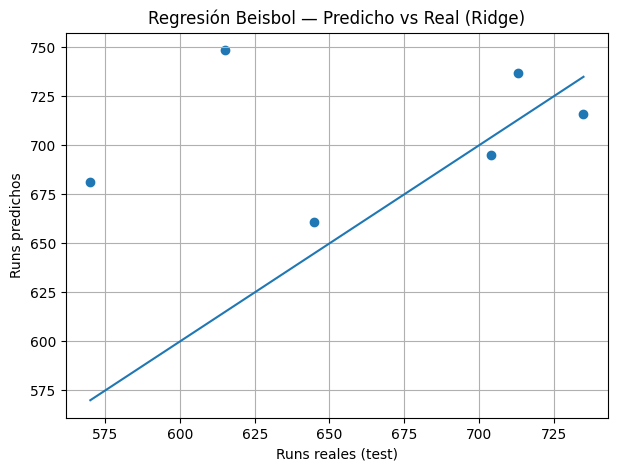

In [8]:
# Gráfica personalizada: Predicho vs Real
plt.figure()
plt.scatter(yte_beis, pred_beis)
plt.plot([min(yte_beis), max(yte_beis)], [min(yte_beis), max(yte_beis)])  # línea y=x
plt.xlabel('Runs reales (test)')
plt.ylabel('Runs predichos')
plt.title('Regresión Beisbol — Predicho vs Real (Ridge)')
fig1_path = save_fig('beisbol_predicho_vs_real')
plt.show()


Top coeficientes (absolutos):
              feature        coef    abs_coef
15     equipos_New_Y.  151.384298  151.384298
1     equipos_Arizona   80.742847   80.742847
18    equipos_Seattle  -78.348063   78.348063
21      equipos_Texas   63.441364   63.441364
8     equipos_Florida  -63.152309   63.152309
2     equipos_Atlanta  -59.533641   59.533641
12  equipos_Milwaukee   57.447116   57.447116
9      equipos_Kansas  -57.297410   57.297410
13  equipos_Minnesota  -57.133729   57.133729
7     equipos_Detroit   54.071756   54.071756


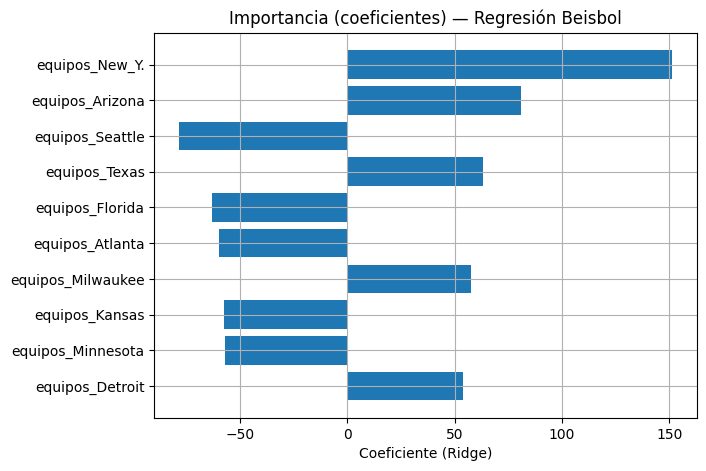

In [9]:
# Importancia de características (coeficientes)
# Recuperar nombres de features del OneHot + scaler
prep = best_reg.named_steps['prep']
model_ridge = best_reg.named_steps['model']

num_names = prep.transformers_[0][2]
cat_encoder: OneHotEncoder = prep.transformers_[1][1]
cat_names = list(cat_encoder.get_feature_names_out(cat_features))
all_names = list(num_names) + cat_names

coefs = model_ridge.coef_.ravel()
coef_df = pd.DataFrame({'feature': all_names, 'coef': coefs, 'abs_coef': np.abs(coefs)})
coef_df = coef_df.sort_values('abs_coef', ascending=False)
print('\nTop coeficientes (absolutos):')
print(coef_df.head(10))

plt.figure()
top_n = min(10, len(coef_df))
plt.barh(coef_df.head(top_n)['feature'][::-1], coef_df.head(top_n)['coef'][::-1])
plt.xlabel('Coeficiente (Ridge)')
plt.title('Importancia (coeficientes) — Regresión Beisbol')
fig2_path = save_fig('beisbol_importancia_coeficientes')
plt.show()

In [10]:
# Guardar modelo de regresión
joblib.dump(best_reg, ARTIFACTS / 'modelo_regresion_beisbol_ridge.joblib')

['artifacts\\modelo_regresion_beisbol_ridge.joblib']

In [11]:
# PARTE 2: 2. Basado en el conjunto de datos "breast_cancer.csv"
# Justificación del algoritmo
"""
Elegí Logistic Regression (con regularización) porque:
- Es un modelo base sólido, interpretable y rápido para clasificación binaria.
- Ofrece probabilidades calibradas y coeficientes interpretables.
- Con estandarización + C/penalty ajustados, logra buen rendimiento.
"""

'\nElegí Logistic Regression (con regularización) porque:\n- Es un modelo base sólido, interpretable y rápido para clasificación binaria.\n- Ofrece probabilidades calibradas y coeficientes interpretables.\n- Con estandarización + C/penalty ajustados, logra buen rendimiento.\n'

In [12]:
# Preprocesamiento y pipeline
# Copia limpia, elimina ID si existe
cancer = cancer_df.copy()
if 'id' in cancer.columns:
    cancer = cancer.drop(columns=['id'])

# Codificar target: M→1, B→0 (u otro esquema si ya está codificado)
if cancer['diagnosis'].dtype == object:
    cancer['diagnosis'] = cancer['diagnosis'].map({'M': 1, 'B': 0})

X_can = cancer.drop(columns=['diagnosis'])
y_can = cancer['diagnosis'].astype(int)

num_features_c = list(X_can.columns)

preprocess_clf = ColumnTransformer([
    ('num', StandardScaler(), num_features_c)
])

logreg = LogisticRegression(max_iter=5000, solver='saga')
clf_pipe = Pipeline([
    ('prep', preprocess_clf),
    ('model', logreg)
])

param_grid_clf = {
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2']
}

In [13]:
# Split + Optimización
Xtr_can, Xte_can, ytr_can, yte_can = train_test_split(X_can, y_can, test_size=0.2, random_state=42, stratify=y_can)

grid_clf = GridSearchCV(
    clf_pipe,
    param_grid=param_grid_clf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_clf.fit(Xtr_can, ytr_can)

best_clf = grid_clf.best_estimator_
cv_auc = grid_clf.best_score_
print('Mejores hiperparámetros (LogReg):', grid_clf.best_params_)
print('CV ROC AUC:', round(cv_auc, 4))

Mejores hiperparámetros (LogReg): {'model__C': 10.0, 'model__penalty': 'l2'}
CV ROC AUC: 0.996


In [14]:
# Evaluación en test y métricas
pred_prob = best_clf.predict_proba(Xte_can)[:, 1]
pred_lab = (pred_prob >= 0.5).astype(int)

acc = accuracy_score(yte_can, pred_lab)
prec = precision_score(yte_can, pred_lab)
rec = recall_score(yte_can, pred_lab)
f1 = f1_score(yte_can, pred_lab)
auc = roc_auc_score(yte_can, pred_prob)

print('\nMétricas (Test) — Clasificación Cáncer de Mama')
print('Accuracy :', round(acc, 3))
print('Precision:', round(prec, 3))
print('Recall   :', round(rec, 3))
print('F1       :', round(f1, 3))
print('ROC AUC  :', round(auc, 3))


Métricas (Test) — Clasificación Cáncer de Mama
Accuracy : 0.974
Precision: 0.976
Recall   : 0.952
F1       : 0.964
ROC AUC  : 0.987


<Figure size 700x500 with 0 Axes>

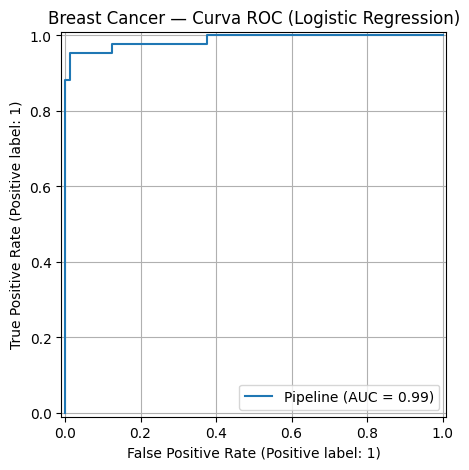

In [15]:
# Gráfica personalizada: Curva ROC
plt.figure()
RocCurveDisplay.from_estimator(best_clf, Xte_can, yte_can)
plt.title('Breast Cancer — Curva ROC (Logistic Regression)')
fig3_path = save_fig('cancer_curva_roc')
plt.show()

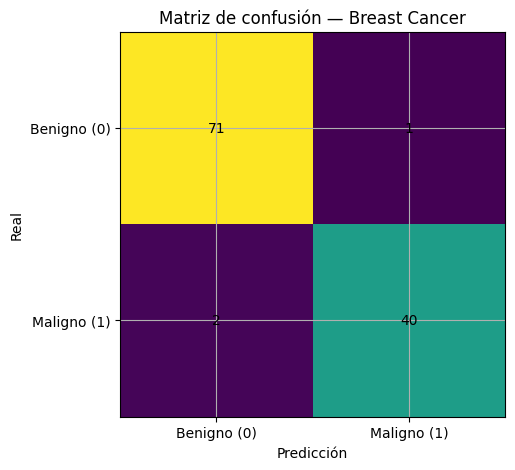

In [16]:
# Matriz de confusión
cm = confusion_matrix(yte_can, pred_lab)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión — Breast Cancer')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0,1], ['Benigno (0)','Maligno (1)'])
plt.yticks([0,1], ['Benigno (0)','Maligno (1)'])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
fig4_path = save_fig('cancer_matriz_confusion')
plt.show()


Top features (|coef|):
                feature      coef  abs_coef
10            radius_se  3.201015  3.201015
21        texture_worst  3.107474  3.107474
13              area_se  2.345295  2.345295
28       symmetry_worst  2.344587  2.344587
26      concavity_worst  2.240549  2.240549
7   concave points_mean  2.214132  2.214132
5      compactness_mean -2.101136  2.101136
15       compactness_se -1.812753  1.812753
17    concave points_se  1.791785  1.791785
23           area_worst  1.713768  1.713768


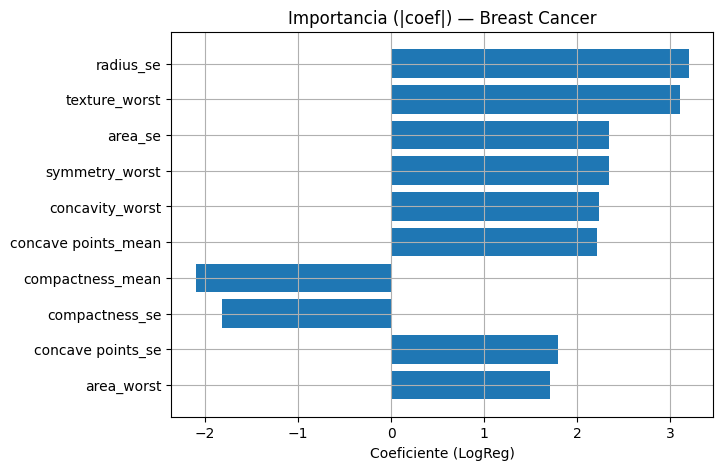

In [17]:
# Interpretación: coeficientes más influyentes (por magnitud)
clf_model: LogisticRegression = best_clf.named_steps['model']
coef = clf_model.coef_.ravel()
feat_imp = pd.DataFrame({'feature': num_features_c, 'coef': coef, 'abs_coef': np.abs(coef)})
feat_imp = feat_imp.sort_values('abs_coef', ascending=False)
print('\nTop features (|coef|):')
print(feat_imp.head(10))

plt.figure()
N = min(10, len(feat_imp))
plt.barh(feat_imp.head(N)['feature'][::-1], feat_imp.head(N)['coef'][::-1])
plt.xlabel('Coeficiente (LogReg)')
plt.title('Importancia (|coef|) — Breast Cancer')
fig5_path = save_fig('cancer_importancia_coeficientes')
plt.show()

In [18]:
# Guardar modelo de clasificación
joblib.dump(best_clf, ARTIFACTS / 'modelo_clasificacion_cancer_logreg.joblib')

['artifacts\\modelo_clasificacion_cancer_logreg.joblib']